Test with radial bases function and make its variation through anistropic shape parameters and spherical harmonics.
Here, the shape parameters are constructed with rotation and scale matrix! Also, spherical harmonics are applied to scale matrix, not with independant term.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def rbf(x, kc, kcov):
    """
        Inputs:
            x: (h, w, d)
            kc: (1, 1, d)
            kcov: (1, 1, d, d)
        Outputs:
            (..., k)
    """
    kcov_inv = np.linalg.inv(kcov)
    offset = x[..., :] - kc  # (n, d)
    out = 1 / (1 + ((offset[..., None] * kcov_inv).sum(-2) * offset).sum(-1))
    return out, offset

def rbf_ch(x, kc, ks, kr, ch):
    """
        Inputs:
            x: (h, w, d)
            kc: (1, 1, d)
            ks: (1, 1, d, d)
            kr: (1, 1, d, d)
            ch: [num_ch]
        Outputs:
            (..., k)
    """
    offset = x[..., :] - kc  # (n, d)
    theta = np.arctan2(offset[..., 1], offset[..., 0]) # (n)
    ch = 1 + ch[0] * np.cos(theta) + ch[1] * np.sin(theta)
    kcov = get_cov_matrix(ch[..., None, None] * ks, kr)
    kcov_inv = np.linalg.inv(kcov)
    out = 1 / (1 + ((offset[..., None] * kcov_inv).sum(-2) * offset).sum(-1))
    return out, offset
    
def rbf_ch2(x, kc, ks, kr, ch):
    """
        Inputs:
            x: (h, w, d)
            kc: (1, 1, d)
            ks: (1, 1, d)
            kr: (1, 1, d, d)
            ch: [num_ch]
        Outputs:
            (..., k)
    """
    offset = x[..., :] - kc  # (n, d)
    theta = np.arctan2(offset[..., 1], offset[..., 0]) # (n)
    ch = 1 + ch[0] * np.cos(theta) * np.sin(theta) + ch[1] * np.cos(2*theta) * np.sin(2*theta) + 0.5 * np.cos(3*theta) * np.sin(3*theta)
    ks_d = np.stack([ks[:, :, 0, 0], ks[:, :, 1,  1]], axis=-1)
    transform = 1 / ch[..., None, None] * (1 / ks_d)[..., None] * kr.swapaxes(-1, -2)
    kcov_inv = np.matmul(transform.swapaxes(-1, -2), transform)

    out = 1 / (1 + ((offset[..., None] * kcov_inv).sum(-2) * offset).sum(-1))
    return out, offset

def get_scale_matrix(s1, s2):
    return np.array([[s1, 0],[0, s2]])

def get_rot_matrix(th):
    th = th / 180 * np.pi
    return np.array([[np.cos(th), np.sin(th)],
                     [-np.sin(th), np.cos(th)]])

def get_cov_matrix(ss1, sr1):
    return np.matmul(np.matmul(np.matmul(sr1, ss1), ss1.swapaxes(-1, -2)), sr1.swapaxes(-1,-2))

def kw_sq_to_ks(kw_sq):
    d = kw_sq.shape[-1]
    w, v = np.linalg.eig(kw_sq)  # [d], [d d]
    w = w[..., None]**(0.5) * np.eye(d)  # [... d d]
    return w, v

In [2]:
# parameter information of target plots
c = np.array([0, 0])
c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = c10 = c11 = c12 = c
ss1 = get_scale_matrix(3.0, 3.0)
sr1 = get_rot_matrix(0)
ss2 = get_scale_matrix(1.5, 4.5)
sr2 = get_rot_matrix(70)
ss3 = get_scale_matrix(1.5, 4.5)
sr3 = get_rot_matrix(-30)

ch = [0.5, 0.5]

func_params = ['rbf_ch', 'rbf_ch_mfs']
c_params = np.stack([c1, c2, c3, c1, c2, c3], axis=0)
s_params = np.stack([ss1, ss2, ss3, ss1, ss2, ss3], axis=0)
r_params = np.stack([sr1, sr2, sr3, sr1, sr2, sr3], axis=0)
freq_params = [0, 0, 0, 2**4, 2**4, 2**4]
n_plot = 6

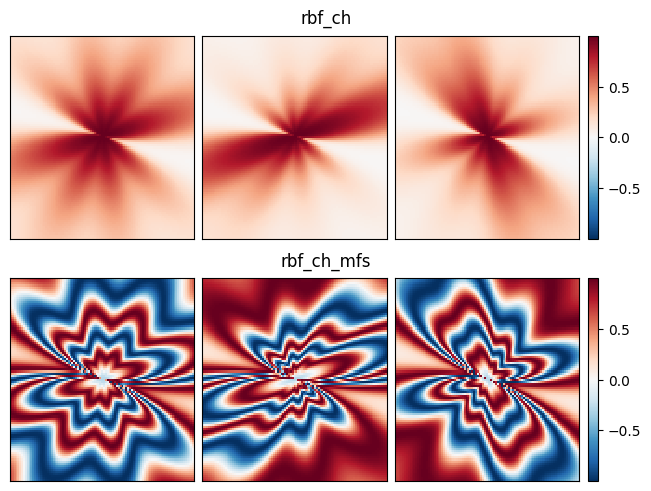

In [3]:
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xy = np.stack([x, y], axis=-1)

n_row = 2
n_col = 3
fig = plt.figure(constrained_layout=True)
subfigs = fig.subfigures(n_row, 1)
for row, subfig in enumerate(subfigs):
    func = func_params[row % n_row]
    subfig.suptitle(func)
    axes = subfig.subplots(nrows=1, ncols=n_col)
    for col, ax in enumerate(axes):
        idx = (row * n_col + col) % n_plot
        kc = c_params[idx]
        
        if func == 'rbf':
            z, _ = rbf(xy, kc[None, None, :], kcov[None, None, :, :])
        elif func == 'rbf_ch':
            ks = s_params[idx]
            kr = r_params[idx]
            z, _ = rbf_ch2(xy, kc[None, None, :], ks[None, None, :, :], kr[None, None, :, :], ch)
        elif func == 'rbf_mfs':
            freq = freq_params[idx]
            z, _ = rbf(xy, kc[None, None, :], kcov[None, None, :, :])
            z = np.sin(z * freq)
        elif func == 'rbf_ch_mfs':
            freq = freq_params[idx]
            ks = s_params[idx]
            kr = r_params[idx]
            z, _ = rbf_ch2(xy, kc[None, None, :], ks[None, None, :, :], kr[None, None, :, :], ch)
            z = np.sin(z * freq)
        else:
            raise NotImplementedError
            
        # x and y are bounds, so z should be the value *inside* those bounds.
        # Therefore, remove the last value from the z array.
        z = z[:-1, :-1]
        z_min, z_max = -np.abs(z).max(), np.abs(z).max()
        
        c = ax.pcolormesh(x, y, z, cmap='RdBu_r', vmin=z_min, vmax=z_max)
        # set the limits of the plot to the limits of the data
        #ax.axis([x.min(), x.max(), y.min(), y.max()])
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
        if col == n_col -1:
            fig.colorbar(c, ax=ax)

plt.show()
